# Tugas Pertemuan 7 – Laporan Pengolahan Citra dengan Python

🔗 **Akses Notebook di Google Colab:**  
[👉 Buka di Google Colab](https://colab.research.google.com/drive/1ja7Ojdoej4FV1ECm5KxUJKFoGuWTYs6m?usp=sharing)

**Nama:** Jeremiah Garcia Tennes

**NPM:** 237006526097

**Program Studi:** Sistem Informasi  

**Mata Kuliah:** Pengolahan Citra  

**Kelas:** R.01

**Bahasa Pemrograman:** Python *(OpenCV, NumPy, scikit-image, matplotlib, pandas)*  

### 📦 Persiapan Lingkungan
Pastikan paket berikut sudah terpasang sebelum menjalankan kode:

=== Evaluation (Adaptive vs Otsu as GT - demo only) ===
Precision: 0.568, Recall: 0.943, F1: 0.709
IoU: 0.549, Dice: 0.709, Accuracy: 0.700


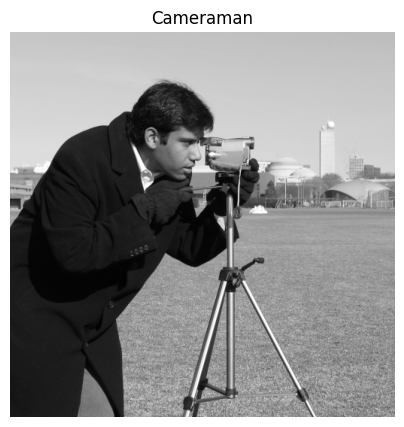

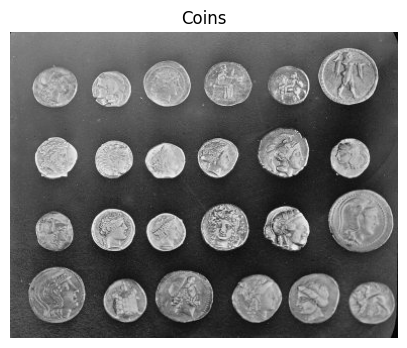

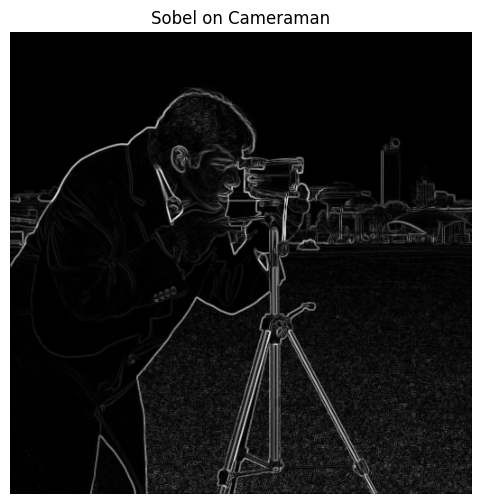

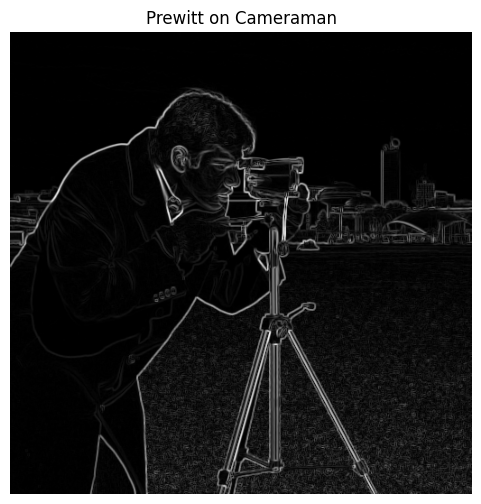

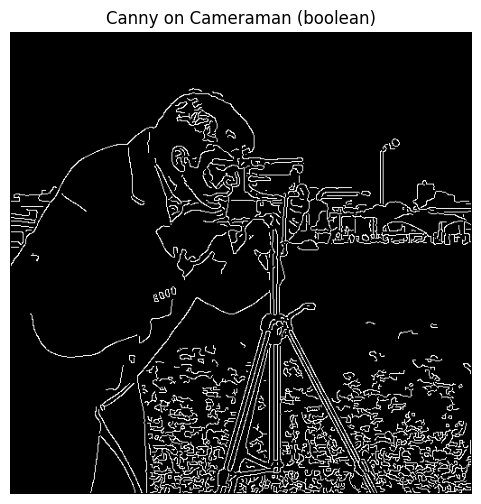

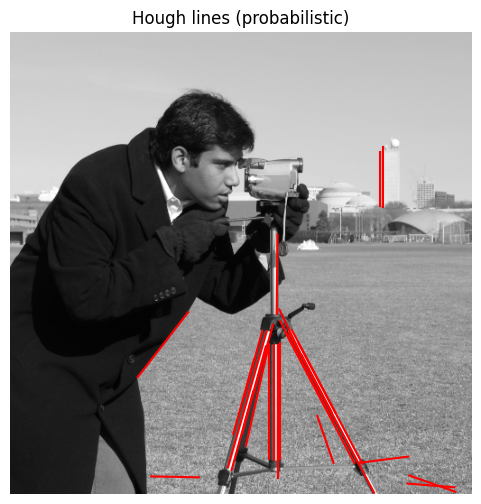

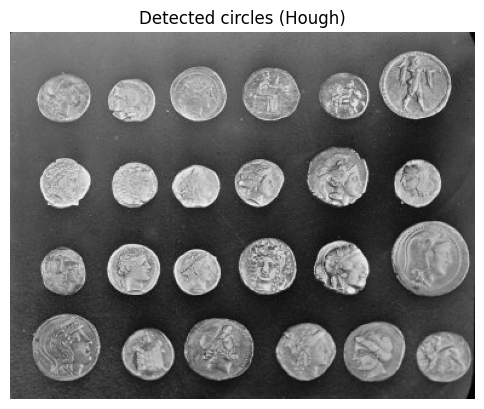

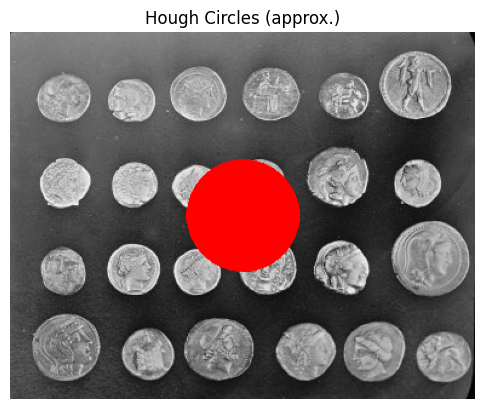

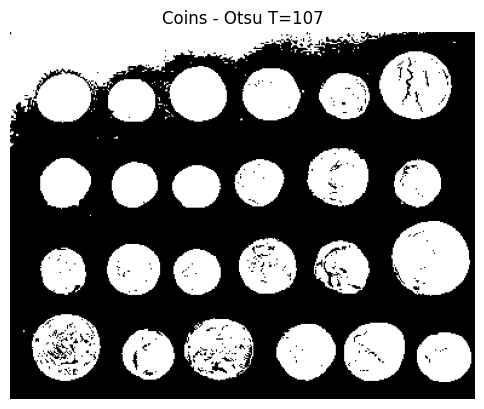

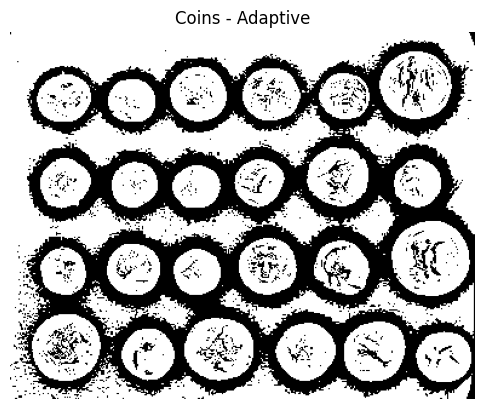

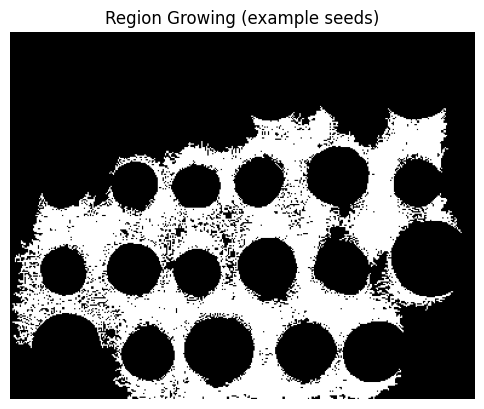

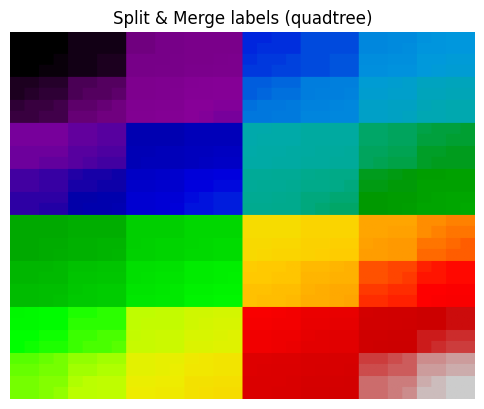

In [1]:
# =========================================================
# Image Segmentation & Edge Detection — Demo Script
# =========================================================
# Requirements: numpy, matplotlib, cv2 (opencv-python), skimage, scipy
# di Colab: !pip install scikit-image opencv-python
# =========================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, color, morphology, util
from skimage.feature import canny
from skimage.filters import threshold_otsu, threshold_local
from skimage.transform import probabilistic_hough_line, hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from scipy import ndimage as ndi
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
from math import sqrt

# ---------------------------
# Utility plotting
# ---------------------------
def imshow(title, img, cmap='gray', size=(6,6)):
    plt.figure(figsize=size)
    if img.ndim==2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis('off')

# ---------------------------
# EDGE DETECTION: Sobel, Prewitt, Canny
# ---------------------------
def sobel_edges(img):
    if img.ndim==3: img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else: img_gray = img
    gx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
    mag = np.hypot(gx, gy)
    mag = (mag / mag.max() * 255).astype(np.uint8)
    return mag

def prewitt_edges(img):
    # skimage implementation for Prewitt
    if img.ndim==3: img_gray = rgb2gray(img)
    else: img_gray = img/255.0 if img.dtype!=np.float64 else img
    from skimage.filters import prewitt_h, prewitt_v
    gx = prewitt_h(img_gray)
    gy = prewitt_v(img_gray)
    mag = np.hypot(gx, gy)
    mag = (mag / mag.max() * 255).astype(np.uint8)
    return mag

def canny_edges(img, sigma=1.0, low_threshold=None, high_threshold=None):
    # returns boolean edge map
    if img.ndim==3: img_gray = rgb2gray(img)
    else:
        img_gray = img/255.0 if img.dtype!=np.float64 else img
    edges = canny(img_gray, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
    return edges

# ---------------------------
# HOUGH TRANSFORM: Lines & Circles
# ---------------------------
def hough_lines_demo(edge_bool, num_peaks=10):
    # Use probabilistic Hough for visualization (from skimage)
    lines = probabilistic_hough_line(edge_bool, threshold=10, line_length=50, line_gap=3)
    return lines

def hough_circles_demo(img_gray, radii_range):
    # img_gray should be 2D grayscale float (0..1)
    if img_gray.max() > 1.0:
        img = img_gray / 255.0
    else:
        img = img_gray
    hough_res = hough_circle(img, radii_range)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, radii_range, total_num_peaks=10)
    circles = list(zip(cx, cy, radii))
    return circles

# ---------------------------
# THRESHOLDING: Global, Adaptive, Otsu
# ---------------------------
def global_threshold(img_gray, T):
    # img_gray uint8 expected
    return (img_gray > T).astype(np.uint8)

def adaptive_threshold(img_gray, block_size=35, offset=10):
    # returns binary mask (0/1)
    if img_gray.dtype != np.uint8:
        img = (img_gray * 255).astype(np.uint8)
    else:
        img = img_gray
    T = threshold_local(img, block_size, offset=offset)
    return (img > T).astype(np.uint8)

def otsu_threshold(img_gray):
    if img_gray.dtype != np.uint8:
        img = (img_gray * 255).astype(np.uint8)
    else:
        img = img_gray
    T = threshold_otsu(img)
    return (img > T).astype(np.uint8), T

# ---------------------------
# REGION GROWING (simple)
# ---------------------------
def region_growing(img_gray, seed_coords, thresh=10):
    """
    img_gray: grayscale uint8
    seed_coords: list of (r,c) seeds
    thresh: maximum intensity difference allowed from region mean
    returns binary mask
    """
    H, W = img_gray.shape
    visited = np.zeros_like(img_gray, dtype=bool)
    mask = np.zeros_like(img_gray, dtype=np.uint8)
    for seed in seed_coords:
        if visited[seed]: continue
        region_pixels = [seed]
        region_sum = float(img_gray[seed])
        region_count = 1
        visited[seed] = True
        mask[seed] = 1
        q = [seed]
        while q:
            r,c = q.pop(0)
            for dr in [-1,0,1]:
                for dc in [-1,0,1]:
                    nr, nc = r+dr, c+dc
                    if nr<0 or nc<0 or nr>=H or nc>=W: continue
                    if visited[nr,nc]: continue
                    diff = abs(int(img_gray[nr,nc]) - region_sum/region_count)
                    if diff <= thresh:
                        visited[nr,nc] = True
                        mask[nr,nc] = 1
                        q.append((nr,nc))
                        region_pixels.append((nr,nc))
                        region_sum += img_gray[nr,nc]
                        region_count += 1
    return mask

# ---------------------------
# SPLIT & MERGE (Quadtree-like)
# ---------------------------
def split_and_merge(img_gray, tol=10, min_size=8):
    """
    Simple split & merge:
    - Split into quads until region variance < tol or size <= min_size
    - Then merge adjacent similar blocks (very simple heuristic)
    Returns labeled image (each region has ID)
    """
    H, W = img_gray.shape
    labels = np.zeros_like(img_gray, dtype=int)
    region_id = 1
    # store blocks as (r0,c0,size)
    blocks = [(0,0,max(H,W))]
    blocks_done = []
    # recursive splitting
    def process_block(r0,c0,h,w):
        nonlocal region_id
        block = img_gray[r0:r0+h, c0:c0+w]
        if h<=min_size or w<=min_size or block.var() <= tol:
            labels[r0:r0+h, c0:c0+w] = region_id
            region_id += 1
        else:
            rh = h//2; cw = w//2
            process_block(r0, c0, rh, cw)
            process_block(r0, c0+cw, rh, w-cw)
            process_block(r0+rh, c0, h-rh, cw)
            process_block(r0+rh, c0+cw, h-rh, w-cw)
    process_block(0,0,H,W)
    return labels

# ---------------------------
# EVALUATION METRICS (binary masks: 0/1)
# ---------------------------
def confusion_elements(gt, pred):
    gt = gt.astype(bool)
    pred = pred.astype(bool)
    TP = np.logical_and(gt, pred).sum()
    FP = np.logical_and(~gt, pred).sum()
    FN = np.logical_and(gt, ~pred).sum()
    TN = np.logical_and(~gt, ~pred).sum()
    return TP, FP, FN, TN

def precision_recall_f1(gt, pred):
    TP, FP, FN, TN = confusion_elements(gt, pred)
    precision = TP / (TP + FP) if (TP+FP)>0 else 0.0
    recall = TP / (TP + FN) if (TP+FN)>0 else 0.0
    f1 = 2*precision*recall / (precision+recall) if (precision+recall)>0 else 0.0
    return precision, recall, f1

def iou_dice(gt, pred):
    gt = gt.astype(bool); pred = pred.astype(bool)
    inter = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    iou = inter / union if union>0 else 0.0
    dice = 2*inter / (gt.sum() + pred.sum()) if (gt.sum()+pred.sum())>0 else 0.0
    return iou, dice

def accuracy(gt, pred):
    TP, FP, FN, TN = confusion_elements(gt, pred)
    return (TP + TN) / (TP + TN + FP + FN)

# ---------------------------
# EXAMPLE WORKFLOW (Demo)
# ---------------------------
if __name__ == "__main__":
    # 1) Load sample images
    cam = data.camera()            # cameraman
    coins = data.coins()           # coins (good for segmentation)
    moon = data.moon()             # moon (for sharpening earlier)
    lena = data.astronaut()        # color example (astronaut)

    # Display examples
    imshow("Cameraman", cam, size=(5,5))
    imshow("Coins", coins, size=(5,5))

    # 2) Edge detection demo
    sob = sobel_edges(cam)
    pre = prewitt_edges(cam)
    can = canny_edges(cam, sigma=1.2)
    imshow("Sobel on Cameraman", sob)
    imshow("Prewitt on Cameraman", pre)
    imshow("Canny on Cameraman (boolean)", can)

    # 3) Hough lines demo (on canny)
    lines = hough_lines_demo(can)
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.imshow(cam, cmap='gray'); ax.set_title("Hough lines (probabilistic)")
    for p0, p1 in lines:
        ax.plot((p0[0], p1[0]), (p0[1], p1[1]), '-r')
    ax.axis('off')

    # 4) Hough circles demo (coins)
    # convert to float [0,1]
    coins_f = coins / 255.0
    radii = np.arange(20, 50, 2)
    circles = hough_circles_demo(coins_f, radii)
    imshow("Detected circles (Hough)", coins, size=(6,6))
    # overlay
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.imshow(coins, cmap='gray')
    for cy, cx, r in circles:
        circy, circx = circle_perimeter(int(cx), int(cy), int(r), shape=coins.shape)
        ax.plot(circx, circy, color='r', linewidth=1)
    ax.set_title("Hough Circles (approx.)"); ax.axis('off')

    # 5) Thresholding demo (Otsu & Adaptive)
    mask_otsu, T = otsu_threshold(coins)
    mask_adapt = adaptive_threshold(coins, block_size=51, offset=10)
    imshow(f"Coins - Otsu T={T}", mask_otsu*255)
    imshow("Coins - Adaptive", mask_adapt*255)

    # 6) Region growing demo (pick some seeds near coins centers)
    # seeds chosen by visual inspection - example seeds:
    seeds = [(170, 70), (165, 250)]
    mask_rg = region_growing(coins.astype(np.uint8), seeds, thresh=12)
    imshow("Region Growing (example seeds)", mask_rg*255)

    # 7) Split & Merge demo
    labels = split_and_merge(coins, tol=50, min_size=16)
    imshow("Split & Merge labels (quadtree)", labels, cmap='nipy_spectral')

    # 8) Evaluation demo
    # For demo: use Otsu as "ground truth" and adaptive as "prediction" (just example)
    gt = mask_otsu.astype(np.uint8)
    pred = mask_adapt.astype(np.uint8)
    prec, rec, f1 = precision_recall_f1(gt, pred)
    iou, dice = iou_dice(gt, pred)
    acc = accuracy(gt, pred)
    print("=== Evaluation (Adaptive vs Otsu as GT - demo only) ===")
    print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")
    print(f"IoU: {iou:.3f}, Dice: {dice:.3f}, Accuracy: {acc:.3f}")

    plt.show()